# Cruise Control Module & Vehicle Model
## DARPA Assured Micro-Patching Project
## Peter Lobato, Matt Campo, Ben Ettlinger
### Version 0

This jupyter notebook contains two parts: (a) a simulated cruise control module (CCM) and (b) a vehicle model (VM).

The CCM takes in vehicle speed and desired setpoint and outputs an accelerator pedal position (APP). The VM takes in APP and outputs an incremental change in vehicle speed. This interaction becomes a loop which runs at 10Hz. 

The vehicle used in this model is a Class 6 Freightliner truck with road load coefficients found here: 

https://www.nrel.gov/docs/fy17osti/64610.pdf

The cruise control module settings can be configured by the user. These include the Kp and Ki terms, (+) and (-) slew rates, speed differential at which the CCM shuts off and integrator time constant.

Version 0-sandbox added time.sleep so that APP, speed measurements go out every 0.1 seconds.

Version 1 - test - took the notebook from my desktop, copied it Main on github, cloned directory on beaglebone, and can load it from the Beaglebone. Making this change to see that I made a change on Branch1, then going to get Branch1 from the Beaglebone.

In [30]:
# Import libraries
import time
import math
import numpy as np
import matplotlib.pyplot as plt
# import pandas as pd
# import xlrd
# pip install numpy==1.19.3


In [31]:
# Define User Variables
#Global Variables
t_interval = .1  # Constant time interval [reflects CAN protocol wanted]

In [32]:
#User-defined variables for CCM
initial_kph = 55  # Initial speed when Cruise Control is activated [kph]
target = 75.0  # Speed wanted to be maintained [kph]
kff = 0
c_kp = 10  # Constant proportional term
c_ki = 0.01  # Constant integral term
itc = 100  # Integral time constant [used per time interval, units are number of time intervals, or 1/10th seconds]
slew_lowLimit = -75  # Low limit for calculated slew rate [%/s]
slew_highLimit = 75
# High limit for calculated slew rate [%/s]
APP = 0  # Initial accelerator pedal position [%]
prev_APP = 0
kph = initial_kph
prev_kph = initial_kph
prev_errors = [0.0 for _ in range(itc)]  # Array of previous errors to calculate integral term
i = 0  # Keeps circular buffer of size itc for error summation
checks = True  # Breaks proccess if errors occur


In [33]:
#Vehicle Model Constants
mass = 11793  # Mass of vehicle [kg]
track_inertia = 1.03 * mass  # Estimated track inertia [kg]
# Constants in quadratic function for steady state road load
a = 579  # [N]
b = 0  # [N/kph]
c = 0.241512  # [N/kph^2]
ratedP = 179 # [kW]

# Using to check results via graph
graph = True
x = [0.0]
y = [initial_kph]
x_value = 0.0
y_value = initial_kph

# grade used as apart of timed drive cycle schedule
grade = 0

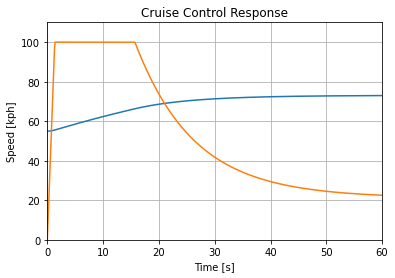

In [34]:
#Cruise Controller
# Functions
def cruise_controller(kph):
    global i
    global prev_APP
    global APP
    global ki
    global kp

    error = kph - target
    prev_errors[i] = error
    i = i + 1
    if i == itc:
        i = 0
    kp = -c_kp * error
    ki = -c_ki * sum(prev_errors)
    APP = kp + ki

    if APP > 100:
        APP = 100
    elif APP < 0:
        APP = 0

    slew_rate = (APP - prev_APP) / t_interval

    if slew_rate < slew_lowLimit:
        slew_rate = slew_lowLimit
        APP = prev_APP + slew_rate * t_interval
    elif slew_rate > slew_highLimit:
        slew_rate = slew_highLimit
        APP = prev_APP + slew_rate * t_interval

    prev_APP = APP
    return APP
    return kp
    return ki
y2 = [APP]


################# SPLIT HERE FOR J1939 #############################


#Vehicle Model
def vehicle_model(APP):
    global kph
    global prev_kph

    accel = (kph - prev_kph) / t_interval
    roadLoad_SS = a + b * kph + c * kph ** 2
    roadLoad_inertial = accel * track_inertia / 3600
    roadLoad_grade = mass * 9.81 * math.sin(math.radians(math.atan(grade / 100)))
    roadLoad_E = roadLoad_SS + roadLoad_inertial + roadLoad_grade

    # look up tables inserted here, input APP, output tractive power)
    # lookup = pd.read_excel('LookupTable.xlsx')
    # lookup.info()

    # starting with => APP*rated power = tractive power [W] as estimate
    tractive_P = APP * ratedP / 100
    tractive_effort = tractive_P / kph * 3600
    delta_v = (tractive_effort - roadLoad_E) * t_interval / track_inertia
    kph = prev_kph + delta_v
    prev_kph = kph
    return kph

while (checks == True):

    # Error Handlers
    if abs(target - kph) > 30:
        print("ERROR: Target speed outside speed difference limit")
        checks = False
        break
    # Main Response Loop
    cruise_controller(kph)
    vehicle_model(APP)
    #time.sleep(0.1)

######################## Plug in two numbers, send out J1939 message ########################
    
    # Generated Graph of Response
    if graph == True:
        x_value+=t_interval
        y_value = kph
        y2_value = APP
        x.append(x_value)
        y.append(y_value)
        y2.append(y2_value)
        #print(x_value)#Just put in to make sure program is running properly
        #print(y_value) #Uncomment these three "print" statements to show numerical values
        #print(y2_value) #Uncomment these three "print" statements to show numerical values
        duration = 60
        if x_value >= duration: #This is where you set the x-axis value for how long you want the loop to run for.
            graph = False
            checks = False
            plt.plot(x,y)
            plt.plot(x,y2)
            plt.xlim(0,duration)
            plt.ylim(0,110)
            plt.grid(True)
            plt.xlabel('Time [s]')
            plt.ylabel('Speed [kph]')
            plt.title('Cruise Control Response')
            plt.show()

In [11]:
#Can delete this cell: just using it to figure out how "time" works
import time
print("before")
time.sleep(5)
print("after")

before
after
